# Proper Subset Analysis

This time hopefully more clean and concise

## Import statements

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration, KMeans
import scipy.cluster.hierarchy as sch
import sys, pickle
from classDeclarations import file_data
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import vstack, csr_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [11]:
with open('gathered_data_enhanced.pkl', "rb") as fp:
    dataset = pickle.load(fp)
print(len(dataset)) # dataset is a list containing three lists of file data(Images, Tabular, and Text data)


3


## One gram Analysis

In [12]:
# Just stacks the file data together for ONE FILE TYPE 
def combine_1gram_data(file_data):
    one_gram_array = np.empty((0, 0))
   
    for data in file_data:
        if one_gram_array.size == 0:
            one_gram_array = data.one_gram_distr_zero
        else:
            one_gram_array = np.vstack((one_gram_array, data.one_gram_distr_zero))
    return one_gram_array

In [14]:
one_gram_img = combine_1gram_data(dataset[0])
one_gram_csv = combine_1gram_data(dataset[1])
one_gram_pdf = combine_1gram_data(dataset[2])
total_dataset_1_gram = np.vstack((one_gram_img, one_gram_csv, one_gram_pdf))
print(total_dataset_1_gram.shape)


(300, 256)


In [22]:
all_file_data = dataset[0] + dataset[1] + dataset[2]
#Input Y: 2-d numpy array with features reduced
#Original file_data to get extractors from
#plot title
def plot_extractors_against_feature_reduction(all_file_data, Y, title):
    no_best_extractor = True
    image_best_extractor = True
    tab_best_extractor = True
    kw_best_extractor = True
    ik_best_extractor = True
    tk_best_extractor = True
    it_best_extractor = True
    all_best_extractor = True
    for i in range(Y.shape[0]):

        if len(all_file_data[i].best_extractors) == 0:
            plt.plot(Y[i][0], Y[i][1], "rx", label="No best extractor" if no_best_extractor else "")
            no_best_extractor = False
        elif len(all_file_data[i].best_extractors) == 1 and "Img" in all_file_data[i].best_extractors:
            plt.plot(Y[i][0], Y[i][1], "ro", label="Image best extractor" if image_best_extractor else "")
            image_best_extractor = False
        elif len(all_file_data[i].best_extractors) == 1 and "Tabular" in all_file_data[i].best_extractors:
            plt.plot(Y[i][0], Y[i][1], "bo", label="Tabular best extractor" if tab_best_extractor else "")
            tab_best_extractor = False
        elif len(all_file_data[i].best_extractors) == 1 and "Keyword" in all_file_data[i].best_extractors:
            plt.plot(Y[i][0], Y[i][1], "go", label="Keyword best extractor" if kw_best_extractor else "")
            kw_best_extractor = False
        elif len(all_file_data[i].best_extractors) == 2 and "Img" in all_file_data[i].best_extractors and "Keyword" in all_file_data[i].best_extractors:
            plt.plot(Y[i][0], Y[i][1], "r^", label="Image/Keyword best extractors" if ik_best_extractor else "")
            ik_best_extractor = False

        elif len(all_file_data[i].best_extractors) == 2 and "Tabular" in all_file_data[i].best_extractors and "Keyword" in all_file_data[i].best_extractors:
            plt.plot(Y[i][0], Y[i][1], "b^", label="Tabular/Keyword best extractors" if tk_best_extractor else "")
            tk_best_extractor = False

        elif len(all_file_data.best_extractors) == 2 and "Img" in all_file_data[i].best_extractors and "Tabular" in all_file_data[i].best_extractors:
            plt.plot(Y[i][0], Y[i][1], "g^", label="Img/Tabular best extractors" if it_best_extractor else "")
            it_best_extractor = False

        else:
            plt.plot(Y[i][0], Y[i][1], "ko", label="All 3 are good extractors" if all_best_extractor else "")
            all_best_extractor = False
    plt.legend()
    plt.title(title)
    plt.show()

## PCA and Kernel PCA

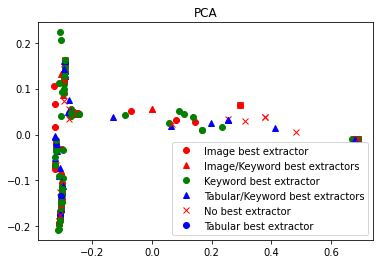

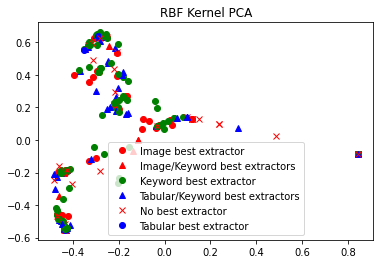

In [23]:
pca = PCA(n_components=2)
onegram_pca = pca.fit_transform(total_dataset_1_gram)

kpca = KernelPCA(n_components=2, kernel='rbf', 
                 gamma=15, random_state=42)
onegram_kpca = kpca.fit_transform(total_dataset_1_gram)

plot_extractors_against_feature_reduction(all_file_data, onegram_pca, "PCA")
plot_extractors_against_feature_reduction(all_file_data, onegram_kpca, "RBF Kernel PCA")



### Trying TSNE 

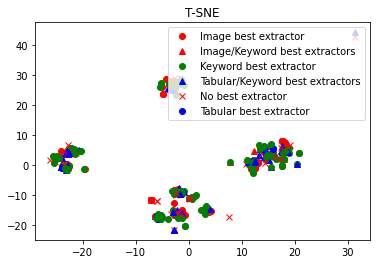

In [28]:
sc = StandardScaler()
pca = PCA(n_components=50)
tsne = TSNE(n_components=2)

tsne_after_pca = Pipeline([
    ('std_scaler', sc),
    #('pca', pca),
    ('tsne', tsne)
])

onegram_tsne = tsne_after_pca.fit_transform(total_dataset_1_gram)
plot_extractors_against_feature_reduction(all_file_data, onegram_tsne, "T-SNE")




## Clustering

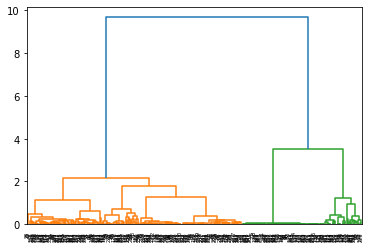

In [29]:
dendrogram = sch.dendrogram(sch.linkage(total_dataset_1_gram, method='ward'))

In [34]:
def generate_agglo_one_gram_plots(dataset, title):
    linkage = ['ward', 'complete', 'average', 'single']
    affinity = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

    for method in linkage:
        if method == 'ward':
            affinities = ['euclidean']
        else:
            affinities = affinity
        for metric in affinities:
            agglo_1_gram = AgglomerativeClustering(n_clusters=2, affinity=metric, linkage=method)
            agglo_1_gram.fit(dataset)
            labels = agglo_1_gram.labels_

            X = total_dataset_1_gram
            plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
            plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')

            plt.title(title + " Affinity:{af} Linkage:{m}".format(af=metric, m=method))
            plt.show()

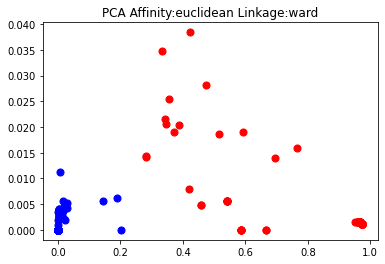

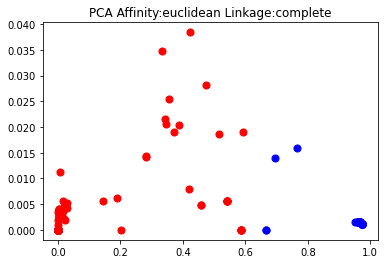

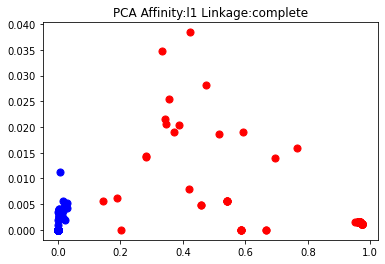

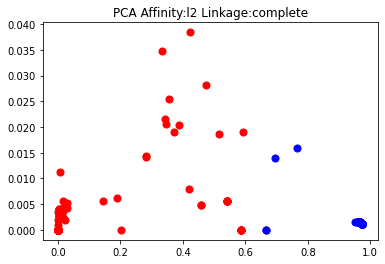

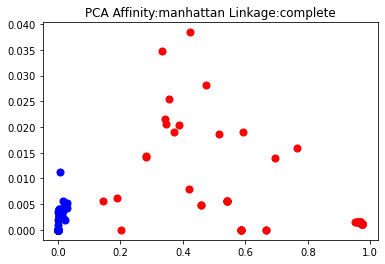

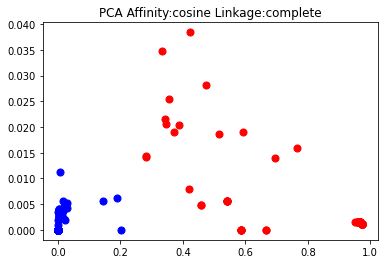

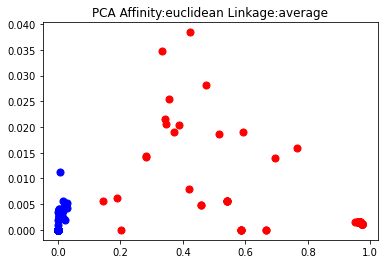

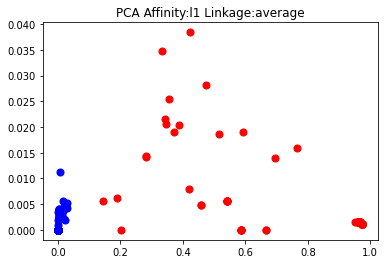

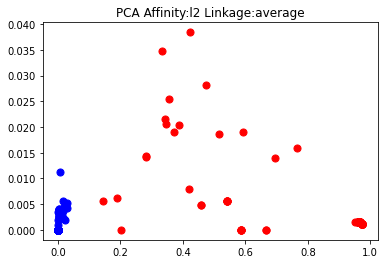

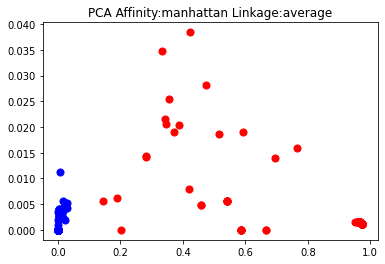

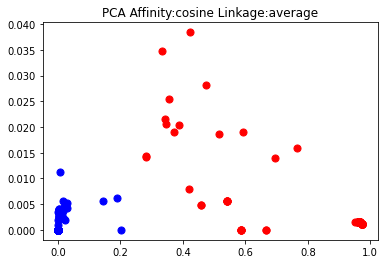

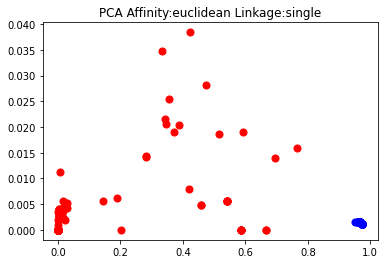

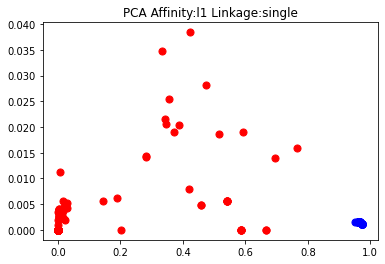

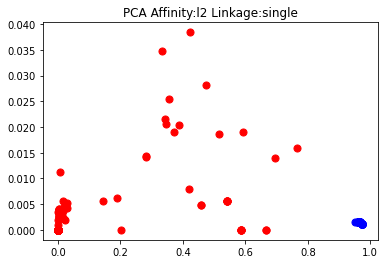

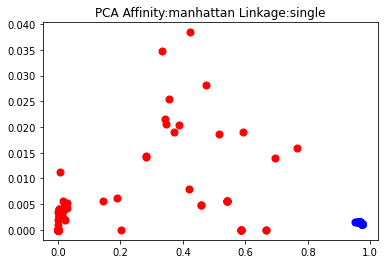

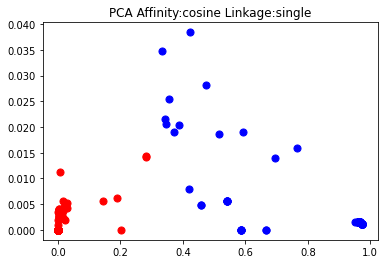

In [35]:
generate_agglo_one_gram_plots(onegram_pca, "PCA")

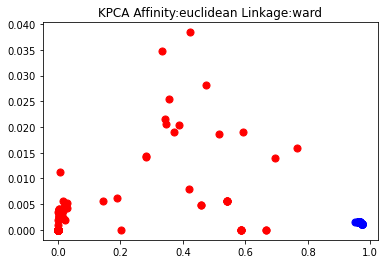

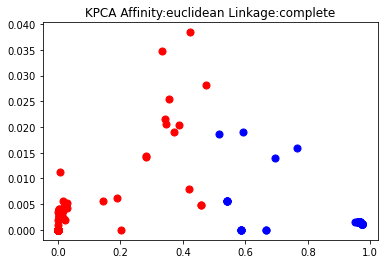

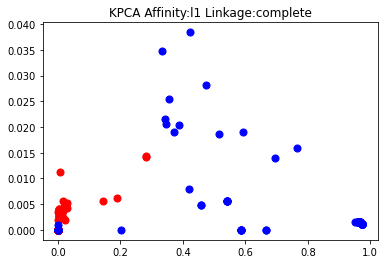

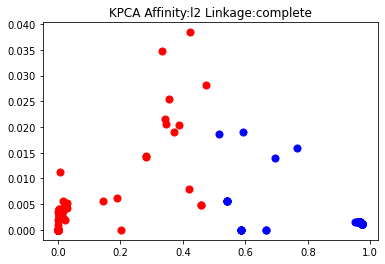

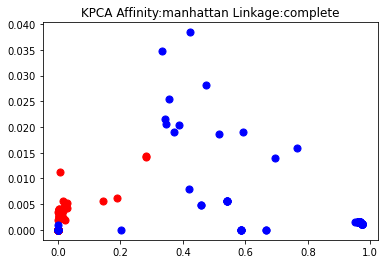

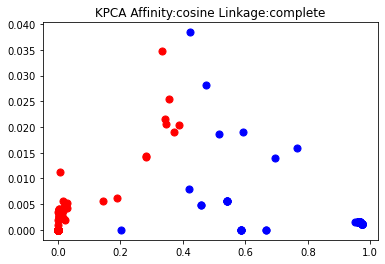

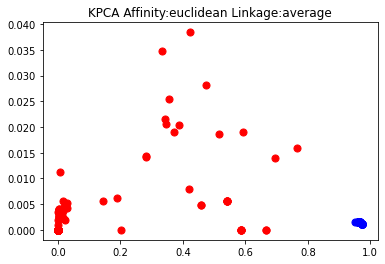

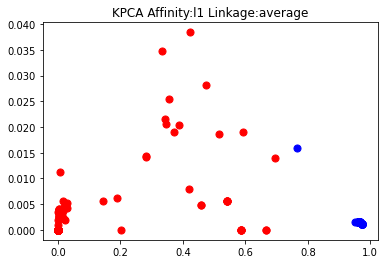

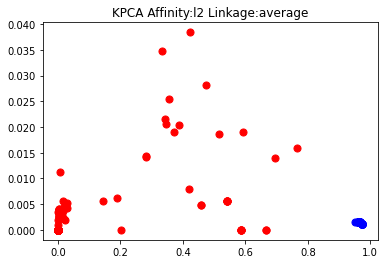

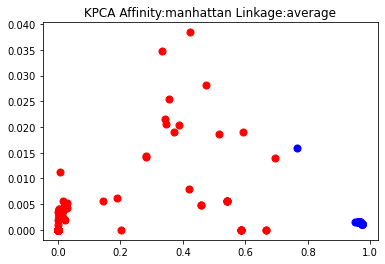

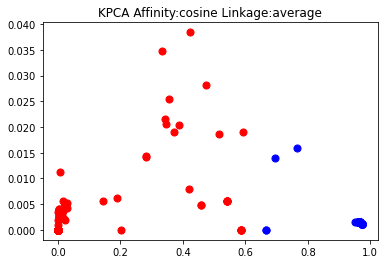

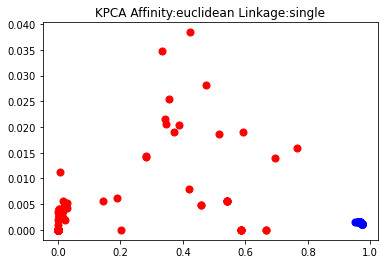

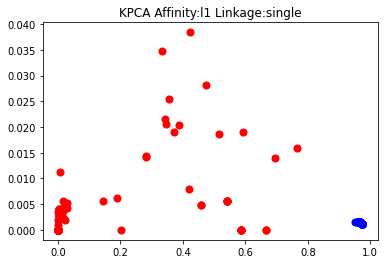

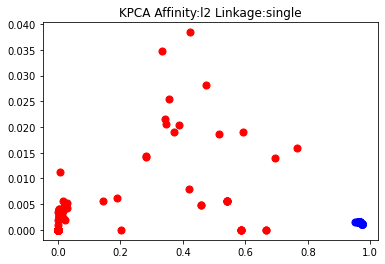

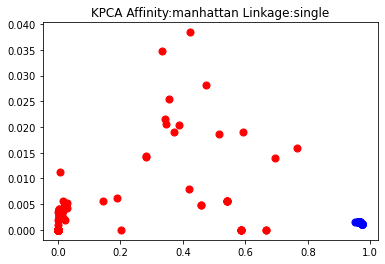

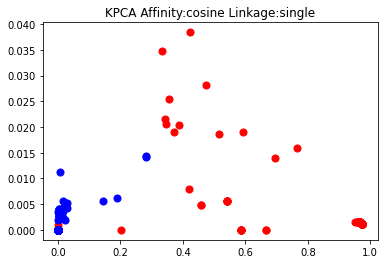

In [36]:
generate_agglo_one_gram_plots(onegram_kpca, "KPCA")

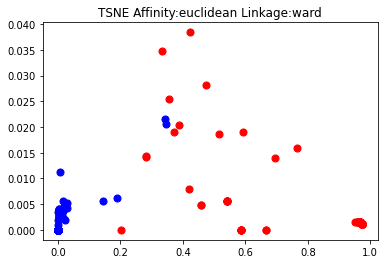

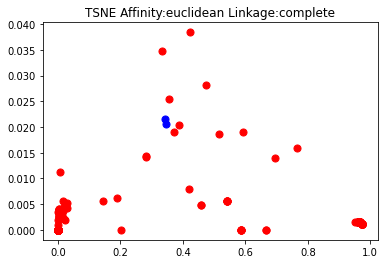

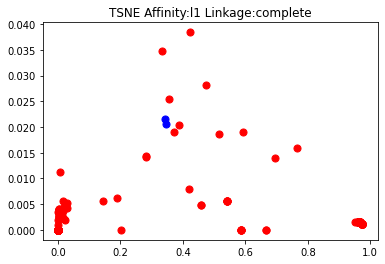

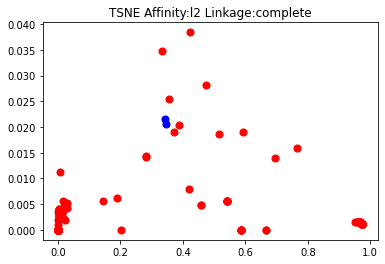

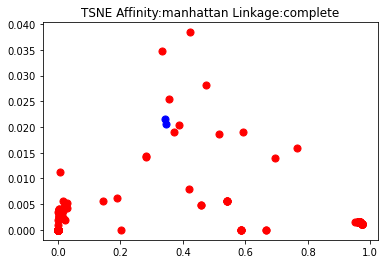

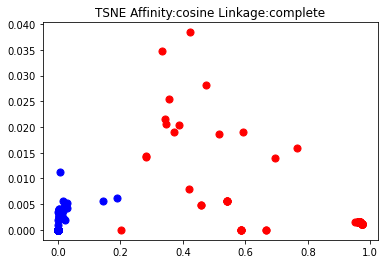

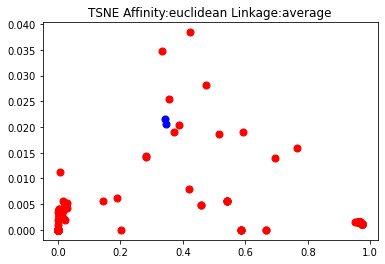

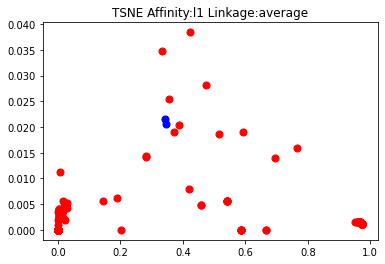

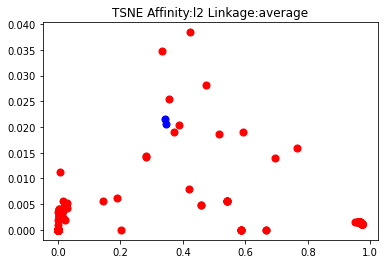

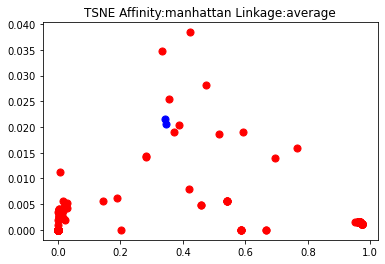

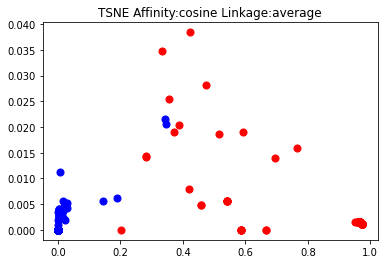

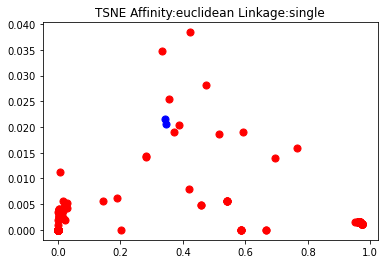

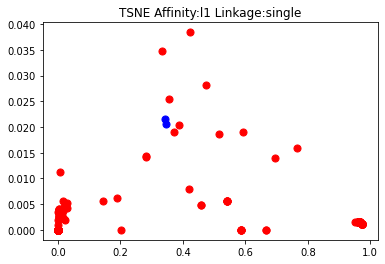

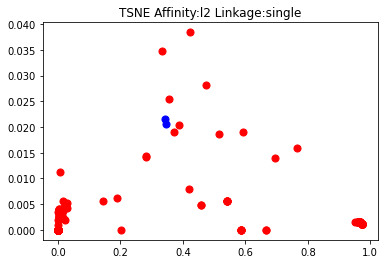

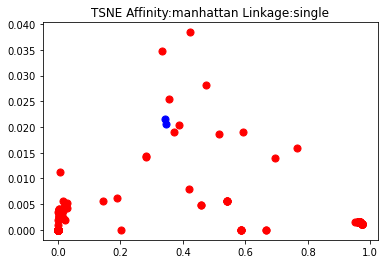

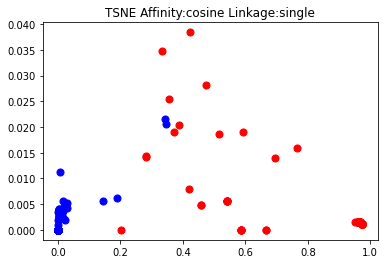

In [37]:
generate_agglo_one_gram_plots(onegram_tsne, "TSNE")